<a href="https://colab.research.google.com/github/chanukaDissanayaka/RideFareClassification/blob/master/Copy_of_Ridefare_submission_29.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#imports

import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from pandas import DataFrame

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier

import numpy as np

RANDOM_SEED = 4

Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
#dataframe = pd.read_csv("/content/train.csv")
#test = pd.read_csv("/content/test.csv")

dataframe = pd.read_csv("/content/gdrive/My Drive/ML_RideFare/Data/train.csv")
test = pd.read_csv("/content/gdrive/My Drive/ML_RideFare/Data/test.csv")

dataframe.isna().sum(axis = 0)
#dataframe = dataframe.fillna(method='ffill')
dataframe = dataframe.dropna()

In [ ]:
def preprocess_train_data(dataframe):
  feature_set = dataframe.iloc[:,1:13]

  features = feature_set

  features['pickup_time'] = pd.to_datetime(features['pickup_time'], format="%m/%d/%Y %H:%M")
  features['drop_time'] = pd.to_datetime(features['drop_time'], format="%m/%d/%Y %H:%M")

  td = features

  td['pickup_time_year'] = td['pickup_time'].dt.year
  td['pickup_time_month'] = td['pickup_time'].dt.month
  td['pickup_time_day'] = td['pickup_time'].dt.day
  td['pickup_time_hour'] = td['pickup_time'].dt.hour
  td['pickup_time_minute'] = td['pickup_time'].dt.minute

  td['drop_time_year'] = td['drop_time'].dt.year
  td['drop_time_month'] = td['drop_time'].dt.month
  td['drop_time_day'] = td['drop_time'].dt.day
  td['drop_time_hour'] = td['drop_time'].dt.hour
  td['drop_time_minute'] = td['drop_time'].dt.minute

  td['day_of_week'] = td['pickup_time'].dt.day_name()
  td['day_of_week'] = OrdinalEncoder().fit_transform(td[['day_of_week']])

  td['duration_calculated'] = td['drop_time'] - td['pickup_time']
  td['duration_calculated'] = td['duration_calculated'].dt.total_seconds().astype(int)

  td = td.drop('pickup_time',1)
  td = td.drop('drop_time',1)

  td = get_trip_distance(td)
  td = get_X_distance(td)
  td = get_Y_distance(td)
  td = get_pick_XY(td)
  td = get_drop_XY(td)
  td = transform_hour(td)
  td = set_time_of_the_day(td)
  td = set_fare_duration(td)
  td = set_driving_duration(td)
  td = get_exact_fare(td)
  td = combine_time_fare(td)
  td = calculate_direction(td)
  

  return td

def get_labels(dataframe):
  label_set = dataframe.iloc[:, 13:14]
  #rev_label_set = label_set
  rev_label_set = label_set.replace({'correct':'incorrect', 'incorrect':'correct'})

  encoder = LabelEncoder()
  encoder.fit(rev_label_set)
  labels = encoder.transform(rev_label_set)
  return labels

def set_time_of_the_day(cleaned_train_set):
  cleaned_train_set.head()
  newFrame = cleaned_train_set
  tt = newFrame

  d0_index = newFrame[(newFrame['pickup_time_hour']>=0) & (newFrame['pickup_time_hour'] < 6 )].index
  tt.loc[d0_index,'time_of_day']=0

  d1_index = newFrame[(newFrame['pickup_time_hour']>=6) & (newFrame['pickup_time_hour'] < 12 )].index
  tt.loc[d1_index,'time_of_day']=1

  d2_index = newFrame[(newFrame['pickup_time_hour']>=12) & (newFrame['pickup_time_hour'] < 18 )].index
  tt.loc[d2_index,'time_of_day']=2

  d3_index = newFrame[(newFrame['pickup_time_hour']>=18) & (newFrame['pickup_time_hour'] < 24 )].index
  tt.loc[d3_index,'time_of_day']=3

  return tt

def haversine_distance(lat1, lon1, lat2, lon2):
  r = 6371
  phi1 = np.radians(lat1)
  phi2 = np.radians(lat2)
  d_phi = np.radians(lat2-lat1)
  d_lambda = np.radians(lon2-lon1)

  a = np.sin(d_phi /2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(d_lambda/2)**2
  res = r*(2* np.arctan2(np.sqrt(a), np.sqrt(1-a)))

  return np.round(res,2)
  return res

def get_trip_distance(frame):
  newFrame = frame
  newFrame["distance"] = haversine_distance(frame['pick_lat'],frame['drop_lat'],frame['pick_lon'],frame['drop_lon'])
  return newFrame

def get_trip_distance_eucld(frame):
  newFrame = frame
  newFrame["distance"] = (((frame['pick_lat']-frame['drop_lat'])**2)+((frame['pick_lon']-frame['drop_lon'])**2)**0.5)
  return newFrame

def get_X_distance(frame):
  newFrame = frame
  newFrame["distance_X"] = ((frame['pick_lat']-frame['drop_lat']))
  return newFrame

def get_Y_distance(frame):
  newFrame = frame
  newFrame["distance_Y"] = ((frame['pick_lon']-frame['drop_lon']))
  return newFrame

def get_pick_XY(frame):
  newFrame = frame
  newFrame["pick_X"] = np.cos(frame['pick_lat'])* np.cos(frame['pick_lon'])
  newFrame["pick_Y"] = np.cos(frame['pick_lat'])* np.sin(frame['pick_lon'])
  return newFrame

def get_drop_XY(frame):
  newFrame = frame
  newFrame["drop_X"] = np.cos(frame['drop_lat'])* np.cos(frame['drop_lon'])
  newFrame["drop_Y"] = np.cos(frame['drop_lat'])* np.sin(frame['drop_lon'])
  return newFrame

def transform_hour(frame):
  newFrame = frame
  newFrame["pick_hour_sin"] = np.sin(np.radians(3*frame['pickup_time_hour']))
  newFrame["drop_hour_sin"] = np.sin(np.radians(3*frame['drop_time_hour']))

  newFrame["pick_hour_cos"] = np.cos(np.radians(3*frame['pickup_time_hour']))
  newFrame["drop_hour_cos"] = np.cos(np.radians(3*frame['drop_time_hour']))
  return newFrame

def set_fare_duration(imputed_train_set):
  df = imputed_train_set

  df['total_fare'] = ((df['fare']-df['fare'].mean())/df['fare'].std() +
                      (df['additional_fare']-df['additional_fare'].mean())/df['additional_fare'].std()+ 
                      (df['meter_waiting_fare']-df['meter_waiting_fare'].mean())/df['meter_waiting_fare'].std())

  df['total_fare'] =  df['fare'] + df['additional_fare'] + df['meter_waiting_fare']
  df['total_additional_fare'] = df['additional_fare'] + df['meter_waiting_fare']
  df['total_waiting_time'] = df['meter_waiting'] + df['meter_waiting_till_pickup']
  df['total_time'] = df['total_waiting_time'] + df['duration']

  df['waiting_factor'] = ((df['meter_waiting']-df['meter_waiting'].mean())/df['meter_waiting'].std() +
                      (df['meter_waiting_fare']-df['meter_waiting_fare'].mean())/df['meter_waiting_fare'].std()+ 
                      (df['meter_waiting_till_pickup']-df['meter_waiting_till_pickup'].mean())/df['meter_waiting_till_pickup'].std())

  return df

def set_driving_duration(train_set):
  df = train_set

  df['driving_duration'] = df['duration'] - df['meter_waiting']
  return df

def get_exact_fare(train_set):
  df = train_set
  df['exact_fare'] = df['fare'] - df['additional_fare']- df['meter_waiting_fare']
  return df

def combine_time_fare(train_set):
  df = train_set

  df['additional'] = ((df['additional_fare']-df['additional_fare'].mean())/df['additional_fare'].std() +
                        (df['meter_waiting_till_pickup']-df['meter_waiting_till_pickup'].mean())/df['meter_waiting_till_pickup'].std())

  df['waiting'] = ((df['meter_waiting']-df['meter_waiting'].mean())/df['meter_waiting'].std() +
                        (df['meter_waiting_fare']-df['meter_waiting_fare'].mean())/df['meter_waiting_fare'].std())

  df['exact'] = ((df['exact_fare']-df['exact_fare'].mean())/df['exact_fare'].std() +
                        (df['driving_duration']-df['driving_duration'].mean())/df['driving_duration'].std())

  return df

def calculate_direction(frame):
    newFrame = frame

    distance_X = frame['distance_X']
    distance_Y = frame['distance_Y']

    result = np.zeros(len(distance_X))
    l = np.sqrt(distance_X**2 + distance_Y**2)
    result[distance_X>0] = (180/np.pi)*np.arcsin(distance_Y[distance_X>0]/l[distance_X>0])
    idx = (distance_X<0) & (distance_Y>0)
    result[idx] = 180 - (180/np.pi)*np.arcsin(distance_Y[idx]/l[idx])
    idx = (distance_X<0) & (distance_Y<0)
    result[idx] = -180 - (180/np.pi)*np.arcsin(distance_Y[idx]/l[idx])
    newFrame['direction'] = result
    return newFrame


In [ ]:
cleaned_train_set = preprocess_train_data(dataframe)
labels = get_labels(dataframe)
cleaned_train_set.head()

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,pickup_time_year,pickup_time_month,pickup_time_day,pickup_time_hour,pickup_time_minute,drop_time_year,drop_time_month,drop_time_day,drop_time_hour,drop_time_minute,day_of_week,duration_calculated,distance,distance_X,distance_Y,pick_X,pick_Y,drop_X,drop_Y,pick_hour_sin,drop_hour_sin,pick_hour_cos,drop_hour_cos,time_of_day,total_fare,total_additional_fare,total_waiting_time,total_time,waiting_factor,driving_duration,exact_fare,additional,waiting,exact,direction
0,10.5,834.0,56.0,0.0000,64.0,6.86252,79.8993,6.90330,79.8783,270.32,2019,11,1,0,20,2019,11,1,0,34,0.0,840,8928.13,-0.04078,0.0210,-0.175519,-0.818213,-0.187363,-0.791950,0.000000,0.000000,1.000000,1.000000,0.0,280.8200,10.5000,120.0,954.0,-0.249539,778.0,259.8200,-0.142215,-0.139866,-0.172774,152.753420
1,10.5,791.0,47.0,0.0000,134.0,6.88589,79.8984,6.91373,79.8923,197.85,2019,11,1,0,56,2019,11,1,1,9,0.0,780,8925.61,-0.02784,0.0061,-0.173513,-0.805325,-0.174935,-0.788535,0.000000,0.052336,1.000000,0.998630,0.0,208.3500,10.5000,181.0,972.0,-0.092330,744.0,187.3500,0.016110,-0.140982,-0.436469,167.641274
2,10.5,1087.0,80.0,0.0000,61.0,6.90839,79.8651,6.93669,79.9146,301.64,2019,11,1,1,8,2019,11,1,1,26,0.0,1080,8922.14,-0.02830,-0.0495,-0.197078,-0.786528,-0.154631,-0.778754,0.052336,0.052336,0.998630,0.998630,0.0,312.1400,10.5000,141.0,1228.0,-0.253348,1007.0,291.1400,-0.149000,-0.136890,0.048871,-119.757345
3,10.5,598.0,271.0,15.6638,68.0,6.92570,79.8895,6.92748,79.8971,82.30,2019,11,1,2,27,2019,11,1,2,37,0.0,600,8920.81,-0.00178,-0.0076,-0.175582,-0.781100,-0.169414,-0.781369,0.104528,0.104528,0.994522,0.994522,0.0,108.4638,26.1638,339.0,937.0,-0.180187,327.0,56.1362,-0.133168,-0.079562,-1.092511,-103.181677
5,10.5,3407.0,182.0,0.0000,112.0,7.13402,79.8969,6.91865,79.8649,1065.02,2019,11,1,5,38,2019,11,1,6,35,0.0,3420,8897.77,0.21537,0.0320,-0.139842,-0.644356,-0.195765,-0.780623,0.258819,0.309017,0.965926,0.951057,0.0,1075.5200,10.5000,294.0,3701.0,-0.125349,3225.0,1054.5200,-0.033649,-0.124242,3.761081,8.451264


In [ ]:
from sklearn.impute import SimpleImputer

cleaned_train_set.duration.fillna(cleaned_train_set.duration_calculated, inplace=True)
cleaned_train_set.head()

imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
dframe = imp_mean.fit_transform(cleaned_train_set)
k = cleaned_train_set.keys()
imputed_train_set = cleaned_train_set
imputed_train_set[k] = dframe
imputed_train_set.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,pickup_time_year,pickup_time_month,pickup_time_day,pickup_time_hour,pickup_time_minute,drop_time_year,drop_time_month,drop_time_day,drop_time_hour,drop_time_minute,day_of_week,duration_calculated,distance,distance_X,distance_Y,pick_X,pick_Y,drop_X,drop_Y,pick_hour_sin,drop_hour_sin,pick_hour_cos,drop_hour_cos,time_of_day,total_fare,total_additional_fare,total_waiting_time,total_time,waiting_factor,driving_duration,exact_fare,additional,waiting,exact,direction,labels
0,10.5,834.0,56.0,0.0000,64.0,6.86252,79.8993,6.90330,79.8783,270.32,2019.0,11.0,1.0,0.0,20.0,2019.0,11.0,1.0,0.0,34.0,0.0,840.0,8928.13,-0.04078,0.0210,-0.175519,-0.818213,-0.187363,-0.791950,0.000000,0.000000,1.000000,1.000000,0.0,280.8200,10.5000,120.0,954.0,-0.249539,778.0,259.8200,-0.142215,-0.139866,-0.172774,152.753420,1.0
1,10.5,791.0,47.0,0.0000,134.0,6.88589,79.8984,6.91373,79.8923,197.85,2019.0,11.0,1.0,0.0,56.0,2019.0,11.0,1.0,1.0,9.0,0.0,780.0,8925.61,-0.02784,0.0061,-0.173513,-0.805325,-0.174935,-0.788535,0.000000,0.052336,1.000000,0.998630,0.0,208.3500,10.5000,181.0,972.0,-0.092330,744.0,187.3500,0.016110,-0.140982,-0.436469,167.641274,1.0
2,10.5,1087.0,80.0,0.0000,61.0,6.90839,79.8651,6.93669,79.9146,301.64,2019.0,11.0,1.0,1.0,8.0,2019.0,11.0,1.0,1.0,26.0,0.0,1080.0,8922.14,-0.02830,-0.0495,-0.197078,-0.786528,-0.154631,-0.778754,0.052336,0.052336,0.998630,0.998630,0.0,312.1400,10.5000,141.0,1228.0,-0.253348,1007.0,291.1400,-0.149000,-0.136890,0.048871,-119.757345,1.0
3,10.5,598.0,271.0,15.6638,68.0,6.92570,79.8895,6.92748,79.8971,82.30,2019.0,11.0,1.0,2.0,27.0,2019.0,11.0,1.0,2.0,37.0,0.0,600.0,8920.81,-0.00178,-0.0076,-0.175582,-0.781100,-0.169414,-0.781369,0.104528,0.104528,0.994522,0.994522,0.0,108.4638,26.1638,339.0,937.0,-0.180187,327.0,56.1362,-0.133168,-0.079562,-1.092511,-103.181677,1.0
5,10.5,3407.0,182.0,0.0000,112.0,7.13402,79.8969,6.91865,79.8649,1065.02,2019.0,11.0,1.0,5.0,38.0,2019.0,11.0,1.0,6.0,35.0,0.0,3420.0,8897.77,0.21537,0.0320,-0.139842,-0.644356,-0.195765,-0.780623,0.258819,0.309017,0.965926,0.951057,0.0,1075.5200,10.5000,294.0,3701.0,-0.125349,3225.0,1054.5200,-0.033649,-0.124242,3.761081,8.451264,1.0


In [ ]:
imputed_train_set.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,pickup_time_year,pickup_time_month,pickup_time_day,pickup_time_hour,pickup_time_minute,drop_time_year,drop_time_month,drop_time_day,drop_time_hour,drop_time_minute,day_of_week,duration_calculated,distance,distance_X,distance_Y,pick_X,pick_Y,drop_X,drop_Y,pick_hour_sin,drop_hour_sin,pick_hour_cos,drop_hour_cos,total_fare,total_additional_fare,total_waiting_time,total_time,waiting_factor,driving_duration,exact_fare,additional,waiting,exact,direction
0,10.5,834.0,56.0,0.0000,64.0,6.86252,79.8993,6.90330,79.8783,270.32,2019.0,11.0,1.0,0.0,20.0,2019.0,11.0,1.0,0.0,34.0,0.0,840.0,8928.13,-0.04078,0.0210,-0.175519,-0.818213,-0.187363,-0.791950,0.000000,0.000000,1.000000,1.000000,280.8200,10.5000,120.0,954.0,-0.249539,778.0,259.8200,-0.142215,-0.139866,-0.172774,152.753420
1,10.5,791.0,47.0,0.0000,134.0,6.88589,79.8984,6.91373,79.8923,197.85,2019.0,11.0,1.0,0.0,56.0,2019.0,11.0,1.0,1.0,9.0,0.0,780.0,8925.61,-0.02784,0.0061,-0.173513,-0.805325,-0.174935,-0.788535,0.000000,0.052336,1.000000,0.998630,208.3500,10.5000,181.0,972.0,-0.092330,744.0,187.3500,0.016110,-0.140982,-0.436469,167.641274
2,10.5,1087.0,80.0,0.0000,61.0,6.90839,79.8651,6.93669,79.9146,301.64,2019.0,11.0,1.0,1.0,8.0,2019.0,11.0,1.0,1.0,26.0,0.0,1080.0,8922.14,-0.02830,-0.0495,-0.197078,-0.786528,-0.154631,-0.778754,0.052336,0.052336,0.998630,0.998630,312.1400,10.5000,141.0,1228.0,-0.253348,1007.0,291.1400,-0.149000,-0.136890,0.048871,-119.757345
3,10.5,598.0,271.0,15.6638,68.0,6.92570,79.8895,6.92748,79.8971,82.30,2019.0,11.0,1.0,2.0,27.0,2019.0,11.0,1.0,2.0,37.0,0.0,600.0,8920.81,-0.00178,-0.0076,-0.175582,-0.781100,-0.169414,-0.781369,0.104528,0.104528,0.994522,0.994522,108.4638,26.1638,339.0,937.0,-0.180187,327.0,56.1362,-0.133168,-0.079562,-1.092511,-103.181677
5,10.5,3407.0,182.0,0.0000,112.0,7.13402,79.8969,6.91865,79.8649,1065.02,2019.0,11.0,1.0,5.0,38.0,2019.0,11.0,1.0,6.0,35.0,0.0,3420.0,8897.77,0.21537,0.0320,-0.139842,-0.644356,-0.195765,-0.780623,0.258819,0.309017,0.965926,0.951057,1075.5200,10.5000,294.0,3701.0,-0.125349,3225.0,1054.5200,-0.033649,-0.124242,3.761081,8.451264


In [ ]:
numeric_cols = ['meter_waiting','meter_waiting_fare','meter_waiting_till_pickup',
               'additional_fare','duration','pick_lat','pick_lon','drop_lat','drop_lon',
               'fare','pickup_time_day','pickup_time_hour','pickup_time_minute']

numeric_cols = ['meter_waiting','meter_waiting_fare','meter_waiting_till_pickup',
               'additional_fare','duration','fare','distance','waiting_factor',
                'distance_X', 'distance_Y']
categorical_cols = []

used_cols = ['additional_fare', 'meter_waiting', 'meter_waiting_fare', 'meter_waiting_till_pickup',
             'distance','distance_X', 'distance_Y','driving_duration','exact_fare','pickup_time_hour']



In [ ]:
#drop outliers

data_exp = imputed_train_set
data_exp['labels'] = labels

#data_exp = data_exp[data_exp.duration<=10000]
#data_exp = data_exp[data_exp.drop_lon>70.0]
#data_exp = data_exp[data_exp.drop_lat<10.0]
#data_exp = data_exp[data_exp.meter_waiting<=20000]
#data_exp = data_exp[data_exp.meter_waiting_till_pickup<=1000]
data_exp.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,pickup_time_year,pickup_time_month,pickup_time_day,pickup_time_hour,pickup_time_minute,drop_time_year,drop_time_month,drop_time_day,drop_time_hour,drop_time_minute,day_of_week,duration_calculated,distance,distance_X,distance_Y,pick_X,pick_Y,drop_X,drop_Y,pick_hour_sin,drop_hour_sin,pick_hour_cos,drop_hour_cos,time_of_day,total_fare,total_additional_fare,total_waiting_time,total_time,waiting_factor,driving_duration,exact_fare,additional,waiting,exact,direction,labels
0,10.5,834.0,56.0,0.0000,64.0,6.86252,79.8993,6.90330,79.8783,270.32,2019.0,11.0,1.0,0.0,20.0,2019.0,11.0,1.0,0.0,34.0,0.0,840.0,8928.13,-0.04078,0.0210,-0.175519,-0.818213,-0.187363,-0.791950,0.000000,0.000000,1.000000,1.000000,0.0,280.8200,10.5000,120.0,954.0,-0.249539,778.0,259.8200,-0.142215,-0.139866,-0.172774,152.753420,1
1,10.5,791.0,47.0,0.0000,134.0,6.88589,79.8984,6.91373,79.8923,197.85,2019.0,11.0,1.0,0.0,56.0,2019.0,11.0,1.0,1.0,9.0,0.0,780.0,8925.61,-0.02784,0.0061,-0.173513,-0.805325,-0.174935,-0.788535,0.000000,0.052336,1.000000,0.998630,0.0,208.3500,10.5000,181.0,972.0,-0.092330,744.0,187.3500,0.016110,-0.140982,-0.436469,167.641274,1
2,10.5,1087.0,80.0,0.0000,61.0,6.90839,79.8651,6.93669,79.9146,301.64,2019.0,11.0,1.0,1.0,8.0,2019.0,11.0,1.0,1.0,26.0,0.0,1080.0,8922.14,-0.02830,-0.0495,-0.197078,-0.786528,-0.154631,-0.778754,0.052336,0.052336,0.998630,0.998630,0.0,312.1400,10.5000,141.0,1228.0,-0.253348,1007.0,291.1400,-0.149000,-0.136890,0.048871,-119.757345,1
3,10.5,598.0,271.0,15.6638,68.0,6.92570,79.8895,6.92748,79.8971,82.30,2019.0,11.0,1.0,2.0,27.0,2019.0,11.0,1.0,2.0,37.0,0.0,600.0,8920.81,-0.00178,-0.0076,-0.175582,-0.781100,-0.169414,-0.781369,0.104528,0.104528,0.994522,0.994522,0.0,108.4638,26.1638,339.0,937.0,-0.180187,327.0,56.1362,-0.133168,-0.079562,-1.092511,-103.181677,1
5,10.5,3407.0,182.0,0.0000,112.0,7.13402,79.8969,6.91865,79.8649,1065.02,2019.0,11.0,1.0,5.0,38.0,2019.0,11.0,1.0,6.0,35.0,0.0,3420.0,8897.77,0.21537,0.0320,-0.139842,-0.644356,-0.195765,-0.780623,0.258819,0.309017,0.965926,0.951057,0.0,1075.5200,10.5000,294.0,3701.0,-0.125349,3225.0,1054.5200,-0.033649,-0.124242,3.761081,8.451264,1


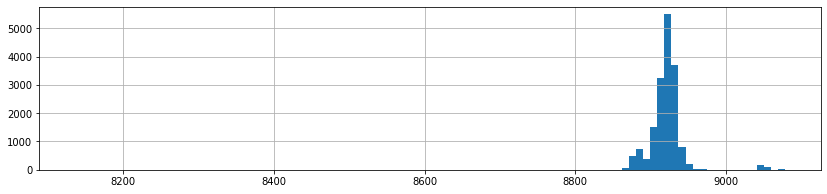

In [ ]:
data_exp.distance.hist(bins=100, figsize=(14,3))

In [ ]:
BB = (79.8184, 81.0097, 5.9376, 8.06493)

In [ ]:
tdd = data_exp.iloc[:, :45]
tdl = data_exp.iloc[:, 45:46]

In [ ]:
tdd.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,pickup_time_year,pickup_time_month,pickup_time_day,pickup_time_hour,pickup_time_minute,drop_time_year,drop_time_month,drop_time_day,drop_time_hour,drop_time_minute,day_of_week,duration_calculated,distance,distance_X,distance_Y,pick_X,pick_Y,drop_X,drop_Y,pick_hour_sin,drop_hour_sin,pick_hour_cos,drop_hour_cos,time_of_day,total_fare,total_additional_fare,total_waiting_time,total_time,waiting_factor,driving_duration,exact_fare,additional,waiting,exact,direction
0,10.5,834.0,56.0,0.0000,64.0,6.86252,79.8993,6.90330,79.8783,270.32,2019.0,11.0,1.0,0.0,20.0,2019.0,11.0,1.0,0.0,34.0,0.0,840.0,8928.13,-0.04078,0.0210,-0.175519,-0.818213,-0.187363,-0.791950,0.000000,0.000000,1.000000,1.000000,0.0,280.8200,10.5000,120.0,954.0,-0.249539,778.0,259.8200,-0.142215,-0.139866,-0.172774,152.753420
1,10.5,791.0,47.0,0.0000,134.0,6.88589,79.8984,6.91373,79.8923,197.85,2019.0,11.0,1.0,0.0,56.0,2019.0,11.0,1.0,1.0,9.0,0.0,780.0,8925.61,-0.02784,0.0061,-0.173513,-0.805325,-0.174935,-0.788535,0.000000,0.052336,1.000000,0.998630,0.0,208.3500,10.5000,181.0,972.0,-0.092330,744.0,187.3500,0.016110,-0.140982,-0.436469,167.641274
2,10.5,1087.0,80.0,0.0000,61.0,6.90839,79.8651,6.93669,79.9146,301.64,2019.0,11.0,1.0,1.0,8.0,2019.0,11.0,1.0,1.0,26.0,0.0,1080.0,8922.14,-0.02830,-0.0495,-0.197078,-0.786528,-0.154631,-0.778754,0.052336,0.052336,0.998630,0.998630,0.0,312.1400,10.5000,141.0,1228.0,-0.253348,1007.0,291.1400,-0.149000,-0.136890,0.048871,-119.757345
3,10.5,598.0,271.0,15.6638,68.0,6.92570,79.8895,6.92748,79.8971,82.30,2019.0,11.0,1.0,2.0,27.0,2019.0,11.0,1.0,2.0,37.0,0.0,600.0,8920.81,-0.00178,-0.0076,-0.175582,-0.781100,-0.169414,-0.781369,0.104528,0.104528,0.994522,0.994522,0.0,108.4638,26.1638,339.0,937.0,-0.180187,327.0,56.1362,-0.133168,-0.079562,-1.092511,-103.181677
5,10.5,3407.0,182.0,0.0000,112.0,7.13402,79.8969,6.91865,79.8649,1065.02,2019.0,11.0,1.0,5.0,38.0,2019.0,11.0,1.0,6.0,35.0,0.0,3420.0,8897.77,0.21537,0.0320,-0.139842,-0.644356,-0.195765,-0.780623,0.258819,0.309017,0.965926,0.951057,0.0,1075.5200,10.5000,294.0,3701.0,-0.125349,3225.0,1054.5200,-0.033649,-0.124242,3.761081,8.451264


In [ ]:
print(tdl.shape, tdd.shape)

(16968, 1) (16968, 45)


In [ ]:
X_train, X_eval, Y_train, Y_eval = train_test_split(
    tdd,
    tdl,
    test_size=0.20,
    shuffle=True,
    stratify=tdl,
    random_state=RANDOM_SEED
)



In [ ]:
numeric_preprocessing_steps = Pipeline([
    ('minmax_scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OrdinalEncoder())
    ])


preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", numeric_preprocessing_steps, numeric_cols),
        ("categorical", categorical_transformer, categorical_cols)
    ],
    remainder = "drop"
)

data_pipeline = Pipeline([
    ("preprocessor", preprocessor)
])


In [ ]:
data_pipeline.fit(X_train)
d_train = data_pipeline.transform(X_train)
d_eval = data_pipeline.transform(X_eval)

In [ ]:
print(d_train.shape, d_eval.shape)
Y_train.shape

(13570, 10) (3393, 10)


(13570, 1)

In [ ]:
d_train[0]

array([5.21634615e-01, 4.25961538e-01, 5.05561173e-03, 2.32908922e-02,
       7.96834055e-02, 4.79259209e-02, 1.04639397e-08, 1.70000000e+01])

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight
sample_w = compute_sample_weight(class_weight={0:10, 1:1}, y=Y_train)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score

gbclf = GradientBoostingClassifier(random_state=2, n_estimators = 1000, max_depth =8, 
                                   subsample = 1.0, verbose = 1)
gbclf.fit(d_train, Y_train, sample_w)
print(gbclf.score(d_eval, Y_eval))
pr = gbclf.predict(d_eval)
print(f1_score(Y_eval, pr, average='macro'))
confusion_matrix(Y_eval, pr)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


      Iter       Train Loss   Remaining Time 
         1           1.2926            1.39m
         2           1.2156            1.40m
         3           1.1456            1.41m
         4           1.0840            1.41m
         5           1.0276            1.40m
         6           0.9745            1.41m
         7           0.9311            1.41m
         8           0.8919            1.40m
         9           0.8582            1.40m
        10           0.8236            1.40m
        20           0.5890            1.40m
        30           0.4520            1.37m
        40           0.3609            1.35m
        50           0.3100            1.33m
        60           0.2656            1.32m
        70           0.2324            1.31m
        80           0.2076            1.29m
        90           0.1852            1.28m
       100           0.1647            1.26m
       200           0.0605            1.12m
       300           0.0262           58.98s
       40

array([[ 191,  114],
       [  39, 3050]])

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score

gbclf = GradientBoostingClassifier(random_state=2, n_estimators = 1000, max_depth =10, 
                                   subsample = 1.0, verbose = 1)
gbclf.fit(d_train, Y_train, sample_w)
print(gbclf.score(d_eval, Y_eval))
pr = gbclf.predict(d_eval)
print(f1_score(Y_eval, pr, average='macro'))
confusion_matrix(Y_eval, pr)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


      Iter       Train Loss   Remaining Time 
         1           1.2764            1.72m
         2           1.1844            1.73m
         3           1.1106            1.72m
         4           1.0340            1.75m
         5           0.9690            1.75m
         6           0.9117            1.76m
         7           0.8600            1.76m
         8           0.8121            1.77m
         9           0.7694            1.76m
        10           0.7362            1.76m
        20           0.4583            1.76m
        30           0.3107            1.74m
        40           0.2165            1.72m
        50           0.1627            1.70m
        60           0.1289            1.68m
        70           0.1015            1.67m
        80           0.0826            1.65m
        90           0.0667            1.63m
       100           0.0558            1.61m
       200           0.0103            1.43m
       300           0.0020            1.24m
       40

array([[ 185,  120],
       [  36, 3053]])

In [ ]:
data_pipeline.fit(tdd)
d_all = data_pipeline.transform(tdd)
y_all = tdl
print(d_all.shape, y_all.shape)

from sklearn.utils.class_weight import compute_sample_weight
sample_w = compute_sample_weight(class_weight={0:1, 1:1}, y=y_all)

gbclf = GradientBoostingClassifier(random_state=2, n_estimators = 850, max_depth =10, 
                                   subsample = 1.0, verbose = 1)

gbclf.fit(d_all, y_all)

(16968, 10) (16968, 1)
      Iter       Train Loss   Remaining Time 
         1           0.5016            1.84m


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


         2           0.4596            1.85m
         3           0.4279            1.86m
         4           0.3986            1.86m
         5           0.3778            1.86m
         6           0.3591            1.86m
         7           0.3463            1.86m
         8           0.3298            1.86m
         9           0.3186            1.86m
        10           0.3064            1.86m
        20           0.2336            1.84m
        30           0.1703            1.82m
        40           0.1275            1.79m
        50           0.0944            1.77m
        60           0.0745            1.74m
        70           0.0602            1.72m
        80           0.0506            1.70m
        90           0.0439            1.68m
       100           0.0392            1.65m
       200           0.0114            1.43m
       300           0.0035            1.21m
       400           0.0010           59.66s
       500           0.0004           45.84s
       600

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=10,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=850,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=2, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=1,
                           warm_start=False)

In [ ]:
cleaned_test_data = preprocess_train_data(test)

test_set = data_pipeline.transform(cleaned_test_data)

In [ ]:
test_set.shape

(8576, 10)

In [ ]:
preds = gbclf.predict(test_set)
print(preds)

[1 0 1 ... 1 1 1]


In [ ]:
preds.shape

(8576,)

In [ ]:
output = pd.DataFrame(test,columns=['tripid'])
output['prediction'] = preds
output.head()

,tripid,prediction
0,213284604,1
1,213286352,0
2,213293973,1
3,213294622,1
4,213298687,1


In [ ]:
output.to_csv('/content/Ridefare_submission_29.csv',index=False)

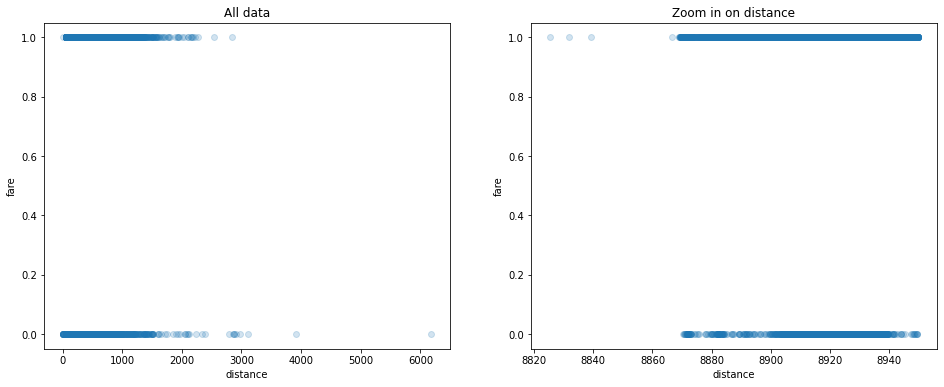

In [ ]:
# scatter plot distance - fare
fig, axs = plt.subplots(1, 2, figsize=(16,6))
axs[0].scatter(data_exp.fare, data_exp.labels, alpha=0.2)
axs[0].set_xlabel('distance')
axs[0].set_ylabel('fare')
axs[0].set_title('All data')

# zoom in on part of data
idx = (data_exp.distance < 8950) & (data_exp.fare < 1000)
axs[1].scatter(data_exp[idx].distance, data_exp[idx].labels, alpha=0.2)
axs[1].set_xlabel('distance')
axs[1].set_ylabel('fare')
axs[1].set_title('Zoom in on distance');

